In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
import h5py

In [3]:
sys.path.append("../..")

from WatChMaL.analysis.multi_plot_utils import multi_disp_learn_hist, multi_compute_roc, multi_plot_roc
from WatChMaL.analysis.comparison_utils import multi_get_masked_data, multi_collapse_test_output
from WatChMaL.analysis.fitqun_comparison_utils import load_mu_fq_output, load_pion_fq_output, load_gamma_fq_output
from WatChMaL.analysis.performance_analysis_utils import remove_indices
from WatChMaL.analysis.performance_analysis_plot_utils import plot_fitqun_binned_performance, plot_momentum_binned_performance, plot_true_momentum_binned_performance

In [4]:
############# define plotting params #############
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
label_dict = {"$\gamma$":0, "$e$":1, "$\mu$":2, "$\pi^0$":3}
inverse_label_dict = {0:"$\gamma$", 1:"$e$", 2:"$\mu$", 3:"$\pi^0$"}
muon_softmax_index_dict = {"e/gamma":0, "mu":1}

## Define fitqun paths

In [5]:
# Retrieve flags
gamma_file_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_gamma_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
e_file_path     = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_e-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
mu_file_path    = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_mu-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
pion_file_path  = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'

fq_mapping_path = '/home/jtindall/WatChMaL_analysis/fitqun_comparison/fitqun_comparison_prep/prep_data/4_class_3M_fitqun_mapping.pickle'

with open('./prep_data/4_class_3M_fitqun_cuts.pickle', 'rb') as handle:
    cuts = pickle.load(handle)

## Load resnet results

In [6]:
############# define run locations #############
short_locs = [#'/home/jtindall/WatChMaL/outputs/2021-04-06/13-38-38/outputs'
              '/home/jtindall/WatChMaL/outputs/2021-04-13/15-55-14/outputs'
              ]

short_titles = ['Short Tank', 'Fitqun']

full_locs = []

full_titles = []

short_linecolor = [c[0] for _ in range(2)]
short_linestyle = ['--' for _ in range(2)]

full_linecolor = [c[1] for _ in full_locs]
full_linestyle = [':' for _ in full_locs]


In [7]:
############# load short tank run data #############
short_raw_output_softmax    = [np.load(loc + "/softmax.npy") for loc in short_locs]
short_raw_actual_labels     = [np.load(loc + "/labels.npy") for loc in short_locs]

In [8]:
locs      = short_locs + full_locs
titles    = short_titles + full_titles
linecolor = short_linecolor + full_linecolor
linestyle = short_linestyle + full_linestyle

## Load h5 Data

In [9]:
# Import test events from h5 file
data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_emgp0_E0to1000MeV_digihits.h5"
data_file = h5py.File(data_path, "r")

print(data_file.keys())

energies   = np.array(data_file['energies'])
angles     = np.array(data_file['angles'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])

<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


In [10]:
idxs_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_4_class_3M_emgp0_idxs.npz'
idxs = np.load(idxs_path, allow_pickle=True)

test_idxs  = idxs['test_idxs']

test_angles    = angles[test_idxs]
test_energies  = energies[test_idxs]
test_positions = positions[test_idxs]
test_labels    = labels[test_idxs]

In [11]:
d_to_wall = np.load('./prep_data/3M_d_to_wall.npz', allow_pickle=True)

test_d_to_wall  = d_to_wall['test_d_to_wall']

In [12]:
true_mom = np.load('./prep_data/3M_momenta.npz', allow_pickle=True)

test_true_mom  = true_mom['test_momenta']

## Generate e/mu plots

## Add fitqun results

In [13]:
fq_scores, fq_labels, fq_mom, fq_masses = load_mu_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path)

short_output_softmax = short_raw_output_softmax + [fq_scores]
short_actual_labels  = short_raw_actual_labels + [fq_labels]

## Filter results

In [14]:
cut_to_apply = cuts['fq_comparison']

filtered_short_softmax  = [remove_indices(softmax, cut_to_apply) for softmax in short_output_softmax]
filtered_labels         = [remove_indices(labels, cut_to_apply) for labels in short_actual_labels]

filtered_fq_mom         = remove_indices(fq_mom, cut_to_apply)
filtered_test_energies  = remove_indices(test_energies, cut_to_apply)
filtered_test_to_wall   = remove_indices(test_d_to_wall, cut_to_apply)
filtered_test_true_mom  = remove_indices(test_true_mom, cut_to_apply)
filtered_test_energies  = remove_indices(test_energies, cut_to_apply)
filtered_test_angles    = remove_indices(test_angles, cut_to_apply)
filtered_test_zenith    = filtered_test_angles[:, 0]
filtered_test_azimuth   = filtered_test_angles[:, 1]

scores_list = [1 - filtered_short_softmax[0][:,2], filtered_short_softmax[1][:,1]]
labels_list = [filtered_labels[0], filtered_labels[1]]
names  = ['ResNet (P(e-) + P(\u03B3))', 'FiTQun']
colors = ['r', 'g']

## Momentum Plots

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Reconstructed Momentum At\nReconstructed Momentum Fixed Bin $\\mu$ Mis-ID Rate'}, xlabel='Reconstructed Momentum [MeV/c]', ylabel='$e$ Signal Efficiency'>

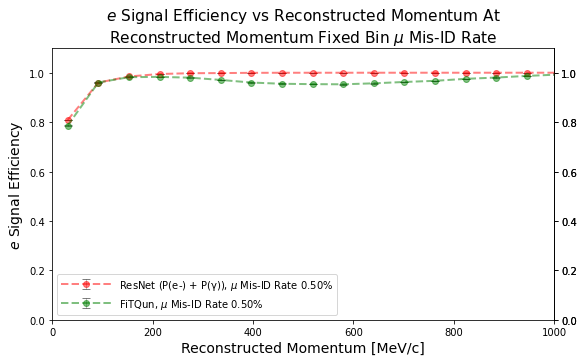

In [15]:
plot_momentum_binned_performance(
                                 reconstructed_momentum = filtered_fq_mom,
                                 scores_list            = scores_list, 
                                 labels_list            = labels_list, 
                                 fpr_fixed_point        = 0.005, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 yrange                 = [0, 1.1],
                                 xrange                 = [0, 1000],
                                 names                  = names,
                                 colors                 = colors
                               )

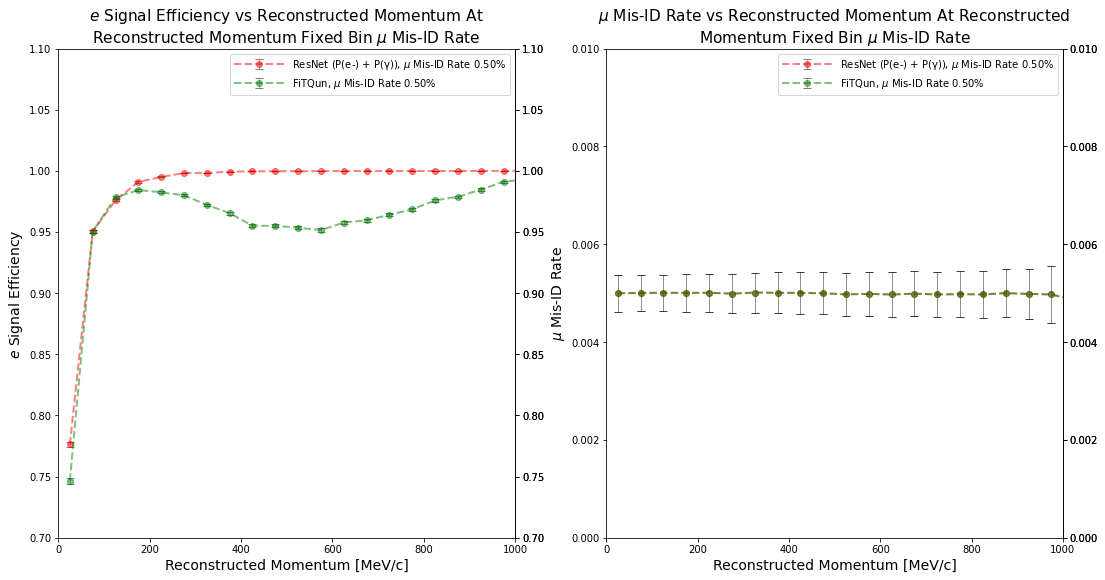

In [16]:
plot_fitqun_binned_performance(scores_list            = scores_list, 
                               labels_list            = labels_list,
                               reconstructed_momentum = filtered_fq_mom,
                               fpr_fixed_point        = 0.005, 
                               index_dict             = label_dict, 
                               recons_mom_bin_size    = 50,
                               marker                 = 'o--',
                               colors                 = colors,
                               title_note             = '',
                               names                  = names
                              )

## Single Variable Plotting

In [17]:
from WatChMaL.analysis.performance_analysis_plot_utils import plot_to_wall_binned_performance, plot_energy_binned_performance, plot_zenith_binned_performance, plot_azimuth_binned_performance

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs To Wall At Reconstructed Momentum\nFixed Bin $\\mu$ Mis-ID Rate'}, xlabel='To Wall [cm]', ylabel='$e$ Signal Efficiency'>

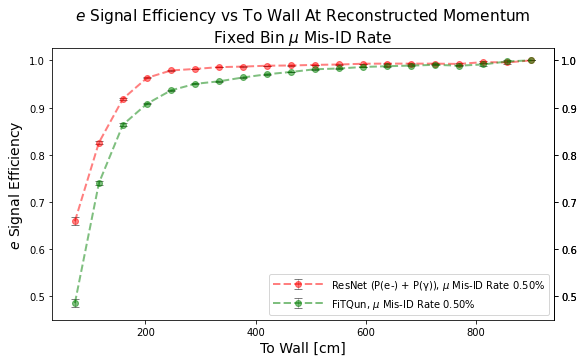

In [18]:
plot_to_wall_binned_performance(scores_list             = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 to_wall_features       = filtered_test_to_wall,
                                 fpr_fixed_point        = 0.005, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Energy At Reconstructed Momentum\nFixed Bin $\\mu$ Mis-ID Rate'}, xlabel='Energy [MeV/$c^2$]', ylabel='$e$ Signal Efficiency'>

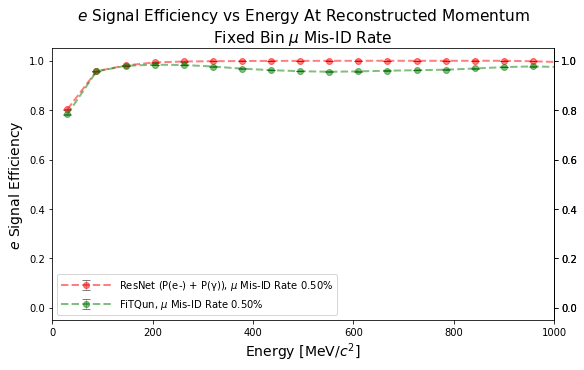

In [19]:
plot_energy_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 energy_features        = filtered_test_energies,
                                 fpr_fixed_point        = 0.005, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 xrange                 = [0, 1000]
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Energy At Reconstructed Momentum\nFixed Bin $\\mu$ Mis-ID Rate'}, xlabel='Energy [MeV/$c^2$]', ylabel='$e$ Signal Efficiency'>

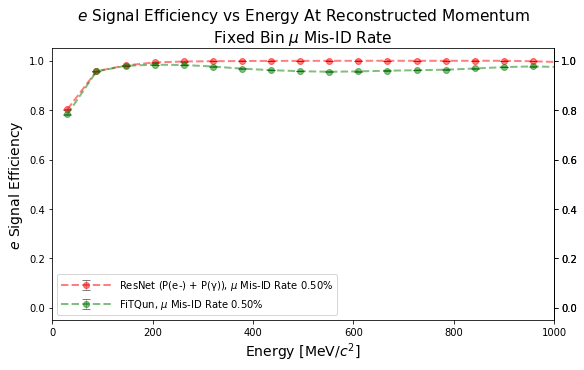

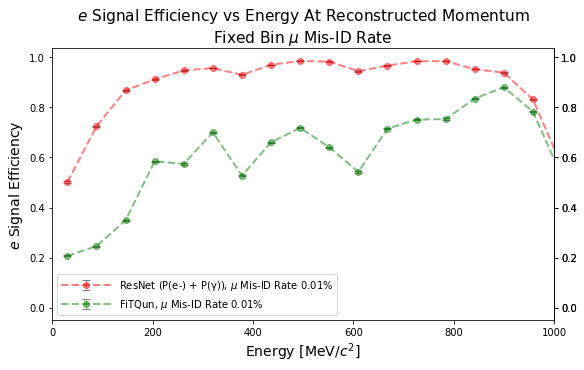

In [20]:

plot_energy_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 energy_features        = filtered_test_energies,
                                 fpr_fixed_point        = 0.005, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 xrange                 = [0, 1000]
                               )

plot_energy_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 energy_features        = filtered_test_energies,
                                 fpr_fixed_point        = 0.0001, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 xrange                 = [0, 1000]
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Zenith At Reconstructed Momentum\nFixed Bin $\\mu$ Mis-ID Rate'}, xlabel='Zenith [Radians]', ylabel='$e$ Signal Efficiency'>

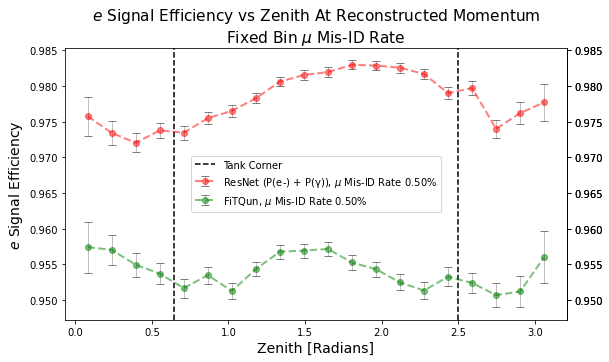

In [21]:
plot_zenith_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 zenith_features        = filtered_test_zenith,
                                 fpr_fixed_point        = 0.005, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\mu$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

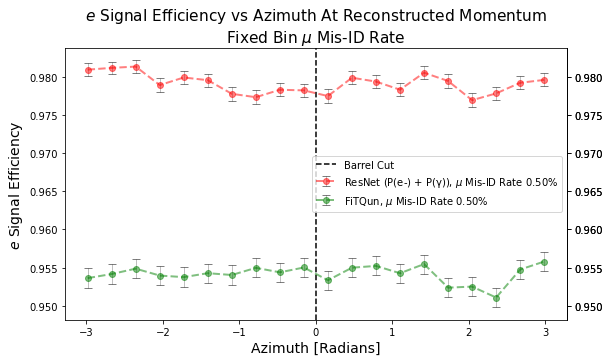

In [22]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.005, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors
                               )

## Multiple Variable Plotting

In [23]:
from WatChMaL.analysis.performance_analysis_plot_utils import plot_to_wall_binned_in_energy, plot_zenith_binned_in_azimuth, plot_azimuth_binned_in_zenith

{'Energy Range $600.0-900.0$ $MeV$', 'Energy Range $300.0-600.0$ $MeV$', 'Energy Range $0.0-300.0$ $MeV$'}


<AxesSubplot:title={'center':'$e$ Signal Efficiency vs To Wall At Reconstructed Momentum\nBin $\\mu$ Mis-ID Rate of 0.5% in Bins of Energy'}, xlabel='To Wall  [cm]', ylabel='$e$ Signal Efficiency'>

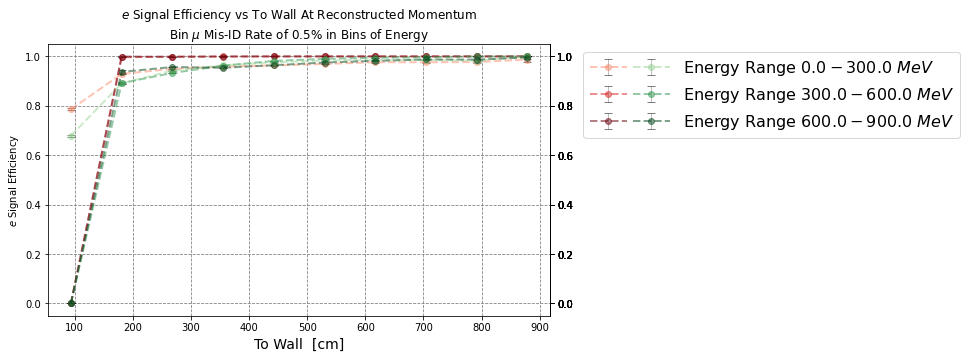

In [24]:
plot_to_wall_binned_in_energy(scores_list                = scores_list, 
                                  labels_list            = labels_list,
                                  reconstructed_momentum = filtered_fq_mom,
                                  binning_features       = filtered_test_energies,
                                  binning_bin_size       = 300,
                                  to_wall_features       = filtered_test_to_wall,
                                  fpr_fixed_point        = 0.005, 
                                  index_dict             = label_dict, 
                                  recons_mom_bin_size    = 50, 
                                  plot_bins              = 10,
                                  names                  = names,
                                 colors                 = colors
                                  )

{'Zenith Range $2.0-2.5$ Radians', 'Zenith Range $1.5-2.0$ Radians', 'Zenith Range $0.5-1.0$ Radians', 'Zenith Range $2.5-3.0$ Radians', 'Zenith Range $1.0-1.5$ Radians', 'Zenith Range $0.0-0.5$ Radians'}
{'Zenith Range $2.0-2.5$ Radians', 'Zenith Range $1.5-2.0$ Radians', 'Zenith Range $0.5-1.0$ Radians', 'Barrel Cut', 'Zenith Range $2.5-3.0$ Radians', 'Zenith Range $1.0-1.5$ Radians', 'Zenith Range $0.0-0.5$ Radians'}


<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nBin $\\mu$ Mis-ID Rate of 0.5% in Bins of Zenith'}, xlabel='Azimuth  [Radians]', ylabel='$e$ Signal Efficiency'>

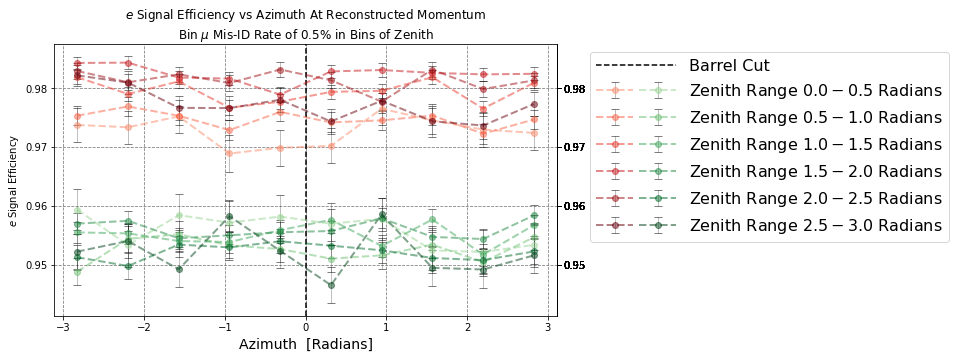

In [25]:
plot_azimuth_binned_in_zenith(scores_list                = scores_list, 
                                  labels_list            = labels_list,
                                  reconstructed_momentum = filtered_fq_mom,
                                  binning_features       = filtered_test_zenith,
                                  binning_bin_size       = 0.5,
                                  azimuth_features       = filtered_test_azimuth,
                                  fpr_fixed_point        = 0.005, 
                                  index_dict             = label_dict, 
                                  recons_mom_bin_size    = 50, 
                                  plot_bins              = 10,
                                  names                  = names,
                                 colors                 = colors
                                  )

{'Azimuth Range $2.0-2.5$ Radians', 'Azimuth Range $1.5-2.0$ Radians', 'Azimuth Range $0.5-1.0$ Radians', 'Azimuth Range $2.5-3.0$ Radians', 'Azimuth Range $1.0-1.5$ Radians', 'Azimuth Range $0.0-0.5$ Radians'}
{'Tank Corner', 'Azimuth Range $2.0-2.5$ Radians', 'Azimuth Range $1.5-2.0$ Radians', 'Azimuth Range $0.5-1.0$ Radians', 'Azimuth Range $2.5-3.0$ Radians', 'Azimuth Range $1.0-1.5$ Radians', 'Azimuth Range $0.0-0.5$ Radians'}


<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Zenith At Reconstructed Momentum\nBin $\\mu$ Mis-ID Rate of 0.5% in Bins of Azimuth'}, xlabel='Zenith  [Radians]', ylabel='$e$ Signal Efficiency'>

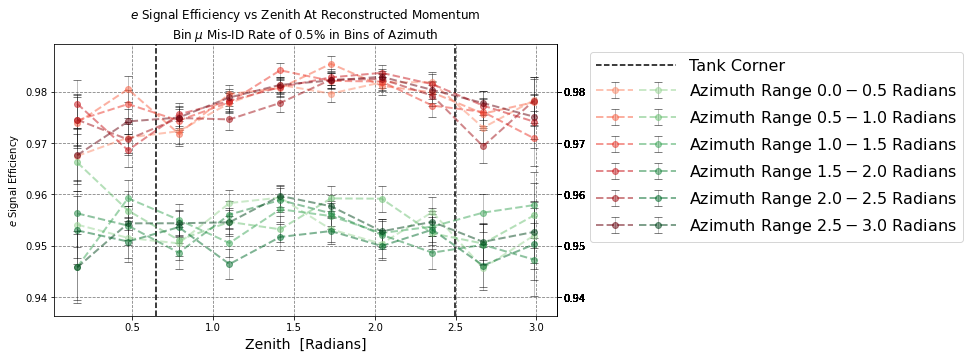

In [26]:
plot_zenith_binned_in_azimuth(scores_list            = scores_list, 
                                  labels_list            = labels_list,
                                  reconstructed_momentum = filtered_fq_mom,
                                  binning_features       = filtered_test_azimuth,
                                  binning_bin_size       = 0.5,
                                  zenith_features        = filtered_test_zenith,
                                  fpr_fixed_point        = 0.005, 
                                  index_dict             = label_dict, 
                                  recons_mom_bin_size    = 50, 
                                  plot_bins              = 10,
                                  names                  = names,
                                 colors                 = colors
                                  )

## Generate $e$-\/$\gamma$ plots

In [27]:
# TODO: must make plotting function compatible with other particles

## Add fitqun results

In [28]:
fq_scores, fq_labels, fq_mom, fq_masses = load_gamma_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path, discriminator='e_v_mu')

short_output_softmax = short_raw_output_softmax + [fq_scores]
short_actual_labels  = short_raw_actual_labels + [fq_labels]

## Filter results

In [29]:
cut_to_apply = cuts['fq_comparison']

filtered_short_softmax  = [remove_indices(softmax, cut_to_apply) for softmax in short_output_softmax]
filtered_labels         = [remove_indices(labels, cut_to_apply) for labels in short_actual_labels]

filtered_fq_mom         = remove_indices(fq_mom, cut_to_apply)
filtered_test_energies  = remove_indices(test_energies, cut_to_apply)
filtered_test_to_wall   = remove_indices(test_d_to_wall, cut_to_apply)
filtered_test_true_mom  = remove_indices(test_true_mom, cut_to_apply)
filtered_test_energies  = remove_indices(test_energies, cut_to_apply)
filtered_test_angles    = remove_indices(test_angles, cut_to_apply)
filtered_test_zenith    = filtered_test_angles[:, 0]
filtered_test_azimuth   = filtered_test_angles[:, 1]

scores_list = [(filtered_short_softmax[0][:,1])/(filtered_short_softmax[0][:,0] + filtered_short_softmax[0][:,1]), filtered_short_softmax[1][:,1]]
labels_list = [filtered_labels[0], filtered_labels[1]]
names  = ['ResNet (P(e-) + P(\u03B3))', 'FiTQun']
colors = ['r', 'g']

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Reconstructed Momentum At\nReconstructed Momentum Fixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Reconstructed Momentum [MeV/c]', ylabel='$e$ Signal Efficiency'>

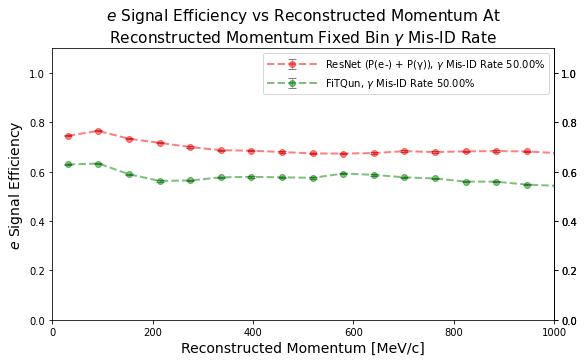

In [30]:
plot_momentum_binned_performance(
                                 reconstructed_momentum = filtered_fq_mom,
                                 scores_list            = scores_list, 
                                 labels_list            = labels_list, 
                                 fpr_fixed_point        = 0.5, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 yrange                 = [0, 1.1],
                                 xrange                 = [0, 1000],
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels=['$e$','$\gamma$']
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs To Wall At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='To Wall [cm]', ylabel='$e$ Signal Efficiency'>

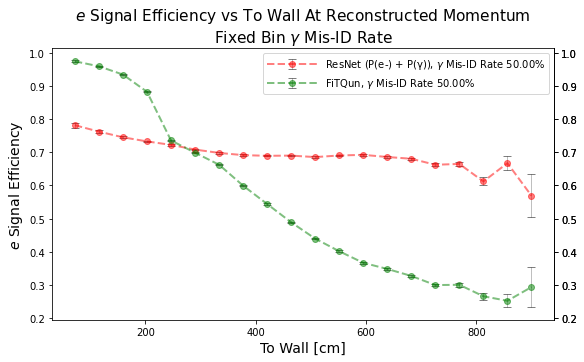

In [31]:
plot_to_wall_binned_performance(scores_list             = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 to_wall_features       = filtered_test_to_wall,
                                 fpr_fixed_point        = 0.5, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels=['$e$','$\gamma$']
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Energy At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Energy [MeV/$c^2$]', ylabel='$e$ Signal Efficiency'>

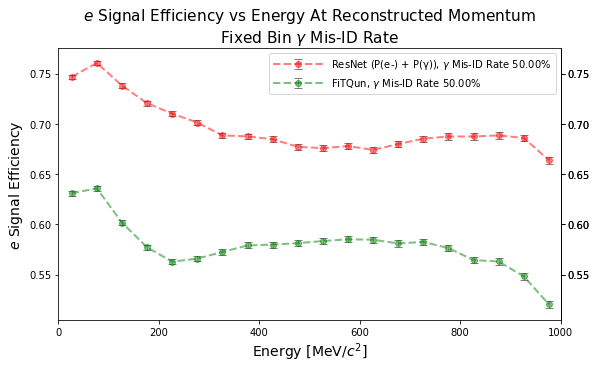

In [32]:
plot_energy_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 energy_features        = filtered_test_energies,
                                 fpr_fixed_point        = 0.5, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 xrange                 = [0, 1000],
                                 desired_labels=['$e$','$\gamma$']
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Zenith At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Zenith [Radians]', ylabel='$e$ Signal Efficiency'>

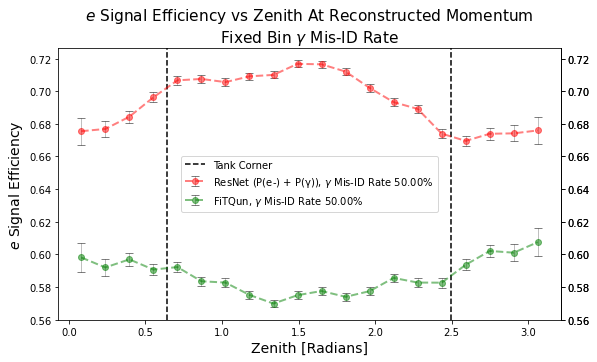

In [33]:
plot_zenith_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 zenith_features        = filtered_test_zenith,
                                 fpr_fixed_point        = 0.5, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$']
                               )

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nFixed Bin $\\gamma$ Mis-ID Rate'}, xlabel='Azimuth [Radians]', ylabel='$e$ Signal Efficiency'>

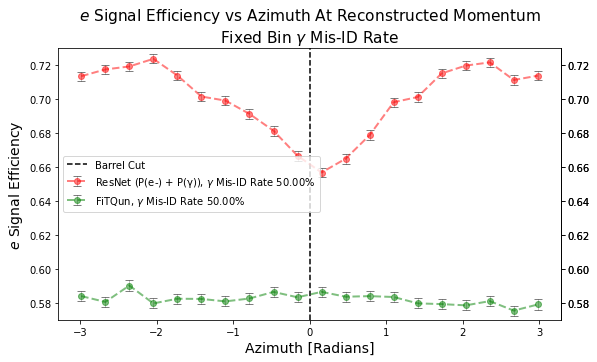

In [34]:
plot_azimuth_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 azimuth_features       = filtered_test_azimuth,
                                 fpr_fixed_point        = 0.5, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 20,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 desired_labels         = ['$e$','$\gamma$'],
                                 yrange                 = [0.57, 0.73]
                               )

## Multiple Variable Plotting

{'Energy Range $400.0-600.0$ $MeV$', 'Energy Range $600.0-800.0$ $MeV$', 'Energy Range $0.0-200.0$ $MeV$', 'Energy Range $200.0-400.0$ $MeV$', 'Energy Range $800.0-1000.0$ $MeV$'}


<AxesSubplot:title={'center':'$e$ Signal Efficiency vs To Wall At Reconstructed Momentum\nBin $\\mu$ Mis-ID Rate of 50.0% in Bins of Energy'}, xlabel='To Wall  [cm]', ylabel='$e$ Signal Efficiency'>

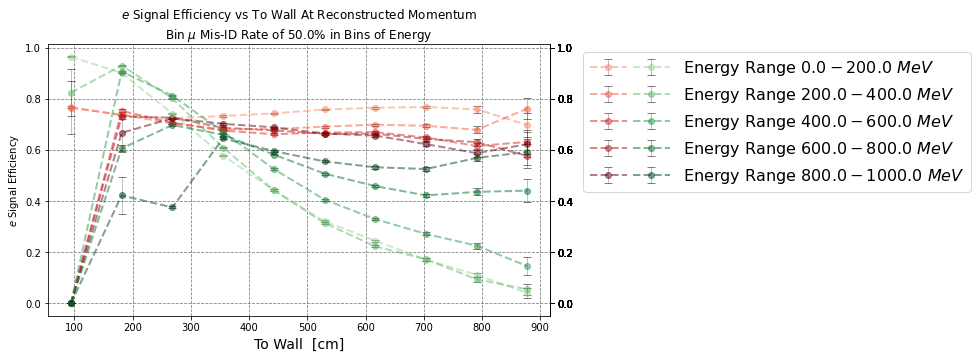

In [35]:
plot_to_wall_binned_in_energy(scores_list            = scores_list, 
                              labels_list            = labels_list,
                              reconstructed_momentum = filtered_fq_mom,
                              binning_features       = filtered_test_energies,
                              binning_bin_size       = 200,
                              to_wall_features       = filtered_test_to_wall,
                              fpr_fixed_point        = 0.5, 
                              index_dict             = label_dict, 
                              recons_mom_bin_size    = 50, 
                              plot_bins              = 10,
                              names                  = names,
                              desired_labels         = ['$e$','$\gamma$'],
                                 colors                 = colors
                              )

{'Zenith Range $2.0-2.5$ Radians', 'Zenith Range $1.5-2.0$ Radians', 'Zenith Range $0.5-1.0$ Radians', 'Zenith Range $2.5-3.0$ Radians', 'Zenith Range $1.0-1.5$ Radians', 'Zenith Range $0.0-0.5$ Radians'}
{'Zenith Range $2.0-2.5$ Radians', 'Zenith Range $1.5-2.0$ Radians', 'Zenith Range $0.5-1.0$ Radians', 'Barrel Cut', 'Zenith Range $2.5-3.0$ Radians', 'Zenith Range $1.0-1.5$ Radians', 'Zenith Range $0.0-0.5$ Radians'}


<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Azimuth At Reconstructed Momentum\nBin $\\mu$ Mis-ID Rate of 50.0% in Bins of Zenith'}, xlabel='Azimuth  [Radians]', ylabel='$e$ Signal Efficiency'>

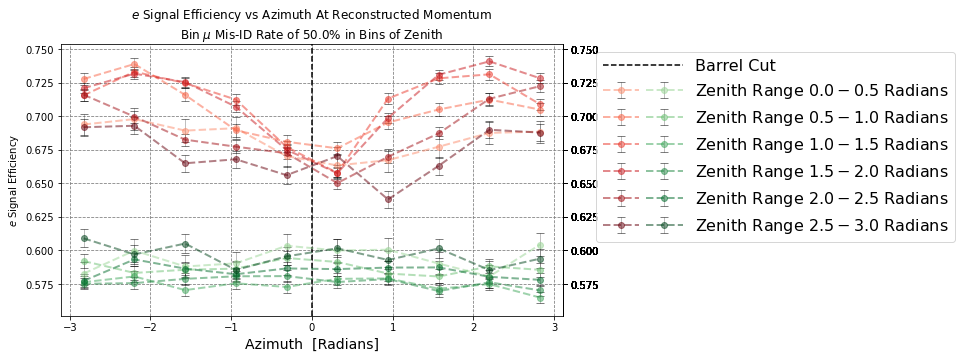

In [36]:
plot_azimuth_binned_in_zenith(scores_list                = scores_list, 
                                  labels_list            = labels_list,
                                  reconstructed_momentum = filtered_fq_mom,
                                  binning_features       = filtered_test_zenith,
                                  binning_bin_size       = 0.5,
                                  azimuth_features       = filtered_test_azimuth,
                                  fpr_fixed_point        = 0.5, 
                                  index_dict             = label_dict, 
                                  recons_mom_bin_size    = 50, 
                                  plot_bins              = 10,
                                  names                  = names,
                                  desired_labels         = ['$e$','$\gamma$'],
                                 colors                 = colors
                                  )

{'Azimuth Range $2.0-2.5$ Radians', 'Azimuth Range $1.5-2.0$ Radians', 'Azimuth Range $0.5-1.0$ Radians', 'Azimuth Range $2.5-3.0$ Radians', 'Azimuth Range $1.0-1.5$ Radians', 'Azimuth Range $0.0-0.5$ Radians'}
{'Tank Corner', 'Azimuth Range $2.0-2.5$ Radians', 'Azimuth Range $1.5-2.0$ Radians', 'Azimuth Range $0.5-1.0$ Radians', 'Azimuth Range $2.5-3.0$ Radians', 'Azimuth Range $1.0-1.5$ Radians', 'Azimuth Range $0.0-0.5$ Radians'}


<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Zenith At Reconstructed Momentum\nBin $\\mu$ Mis-ID Rate of 50.0% in Bins of Azimuth'}, xlabel='Zenith  [Radians]', ylabel='$e$ Signal Efficiency'>

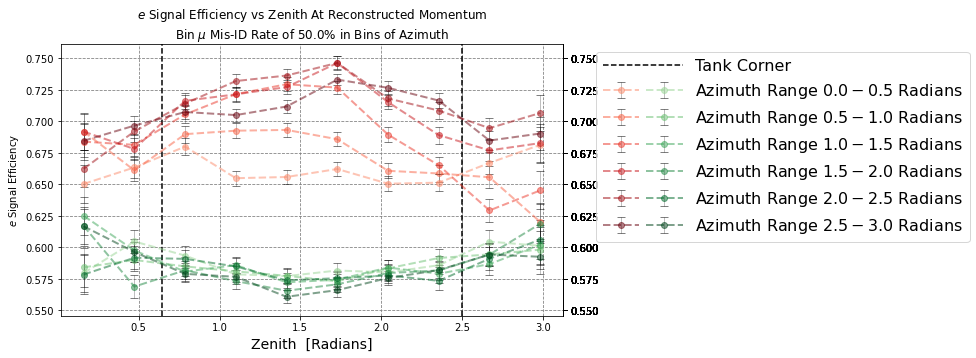

In [37]:
plot_zenith_binned_in_azimuth(scores_list                = scores_list, 
                                  labels_list            = labels_list,
                                  reconstructed_momentum = filtered_fq_mom,
                                  binning_features       = filtered_test_azimuth,
                                  binning_bin_size       = 0.5,
                                  zenith_features        = filtered_test_zenith,
                                  fpr_fixed_point        = 0.5, 
                                  index_dict             = label_dict, 
                                  recons_mom_bin_size    = 50, 
                                  plot_bins              = 10,
                                  names                  = names,
                                  desired_labels         = ['$e$','$\gamma$'] ,
                                 colors                 = colors
                                  )

## Load Pion fitqun Data

In [38]:
 from WatChMaL.analysis.performance_analysis_plot_utils import plot_single_var_pion_binned_performance, plot_pion_multi_var_binned_performance

In [39]:
pion_fq_scores, pion_fq_labels, pion_fq_mom, pion_fq_masses = load_pion_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path)

short_output_softmax = short_raw_output_softmax + [pion_fq_scores]
short_actual_labels  = short_raw_actual_labels + [pion_fq_labels]

## Filter results

In [40]:
cut_to_apply = cuts['fq_comparison_pi0']

filtered_short_softmax  = [remove_indices(softmax, cut_to_apply) for softmax in short_output_softmax]
filtered_labels         = [remove_indices(labels, cut_to_apply) for labels in short_actual_labels]

filtered_fq_mom         = remove_indices(fq_mom, cut_to_apply)
filtered_test_energies  = remove_indices(test_energies, cut_to_apply)
filtered_test_to_wall   = remove_indices(test_d_to_wall, cut_to_apply)
filtered_test_true_mom  = remove_indices(test_true_mom, cut_to_apply)
filtered_test_energies  = remove_indices(test_energies, cut_to_apply)
filtered_test_angles    = remove_indices(test_angles, cut_to_apply)
filtered_test_zenith    = filtered_test_angles[:, 0]
filtered_test_azimuth   = filtered_test_angles[:, 1]

filtered_pion_fq_scores = remove_indices(pion_fq_scores, cuts['fq_comparison_pi0'])
filtered_pion_fq_labels = remove_indices(pion_fq_labels, cuts['fq_comparison_pi0'])
filtered_pion_fq_mom    = remove_indices(pion_fq_mom, cuts['fq_comparison_pi0'])
filtered_pion_fq_masses = remove_indices(pion_fq_masses, cuts['fq_comparison_pi0'])

scores_list = [(filtered_short_softmax[0][:,0] + filtered_short_softmax[0][:,1]) / (filtered_short_softmax[0][:,0] + filtered_short_softmax[0][:,1] + filtered_short_softmax[0][:,3]), filtered_short_softmax[1][:,1]]
labels_list = [filtered_labels[0], filtered_labels[1]]
names  = ['ResNet (1 - P($\pi_0$))', 'ResNet P(e-) / (P(e-) + P($\pi_0$))']
colors = ['r', 'g']

### Pi0 Cut Data

In [41]:
p0 = [15, 30, 30, 475, 1075, 945, 370, 255, 220, 195, 210, 160, 165, 190, 330, 205, 260, 290, 530, 555]
p1 = [-1.2, -6.5, -1.2, -7.6, -14.9, -13.8, -4.8, -2.9, -2.5, -2.5, -3.4, -2, -2.3, -3.2, -7.9, -3.8, -6.1, -6.8, -17.1, -19.7]

## Generate plots

In [42]:
from matplotlib.lines import Line2D
from matplotlib.container import ErrorbarContainer
from matplotlib.collections import LineCollection

Empty bin
Empty bin


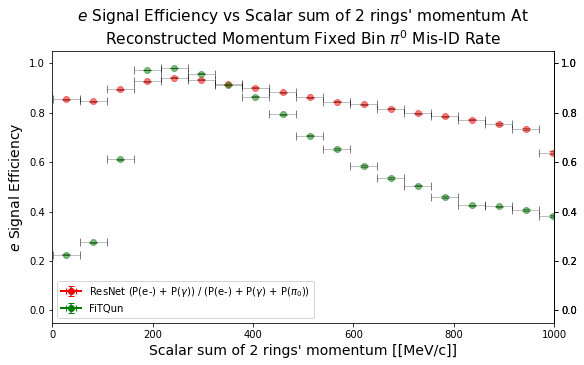

In [43]:
fig, axes = plt.subplots(1,1,figsize=(9,5), facecolor='w')


plot_momentum_binned_performance(scores_list            = [scores_list[0]], 
                                 labels_list            = [labels_list[0]],
                                 reconstructed_momentum = filtered_pion_fq_mom,
                                 fpr_fixed_point        = 0.05, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 30,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 marker                 = 'o',
                                 xrange                 = [0, 1000],
                                 #yrange                 = yrange,
                                 ax                     = axes,
                                 desired_labels         = ['$e$',"$\pi^0$"],
                                 show_x_err             = True
                               )
'''

plot_pion_fixed_operating_performance(scores                 = scores_list[0],
                                      labels                 = labels_list[0],  
                                      fixed_binning_features = filtered_pion_fq_mom,
                                      fixed_bin_label        = 'Reconstructed Momentum',
                                      plot_binning_features  = filtered_pion_fq_mom,
                                      plot_bin_label         = 'Scalar sum of 2 rings\' momentum',
                                      p0                     = p0, 
                                      p1                     = p1, 
                                      pi0mass                = filtered_pion_fq_masses,
                                      fpr_fixed_point        = 0.05, 
                                      index_dict             = label_dict, 
                                      fixed_bin_size         = 50, 
                                      plot_bins              = 30, 
                                      xrange                 = [0, 1000],
                                      marker                 = 'o',
                                      color                  = 'r',
                                      title_note             = '',
                                      metric                 = 'efficiency',
                                      #yrange                  = [0.85, 1.01]
                                      ax                     = axes,
                                      publication=True
                                      )
'''
plot_single_var_pion_binned_performance(scores               = scores_list[1],
                                      labels                 = labels_list[1],  
                                      fixed_binning_features = filtered_pion_fq_mom,
                                      fixed_bin_label        = 'Reconstructed Momentum',
                                      plot_binning_features  = filtered_pion_fq_mom,
                                      plot_bin_label         = 'Scalar sum of 2 rings\' momentum',
                                      p0                     = p0, 
                                      p1                     = p1, 
                                      pi0mass                = filtered_pion_fq_masses,
                                      fpr_fixed_point        = 0.05, 
                                      index_dict             = label_dict, 
                                      fixed_bin_size         = 50, 
                                      plot_bins              = 30, 
                                      xrange                 = [0, 1000],
                                      marker                 = 'o',
                                      color                  = 'g',
                                      title_note             = '',
                                      metric                 = 'efficiency',
                                      #yrange                  = [0.85, 1.01]
                                      ax                     = axes,
                                      publication_style      = True,
                                      names                  = names
                                      )


custom_lines = [Line2D([0], [0], marker='o', linewidth=2, color='r', label='Scatter',
                          markerfacecolor='r'),
                Line2D([0], [0], marker='o', linewidth=2, color='g', label='Scatter',
                          markerfacecolor='g'),
                ]

barline = LineCollection(np.empty((2,2,2)))
err_lines = [ErrorbarContainer((line, [line], [barline]), has_xerr=True, has_yerr=True) for line in custom_lines]
labels = ['ResNet (P(e-) + P($\gamma$)) / (P(e-) + P($\gamma$) + P($\pi_0$))'.format(0.005*100),
          'FiTQun']

leg = axes.legend(handles=err_lines, labels=labels, handlelength=2.0)


Empty bin
Empty bin


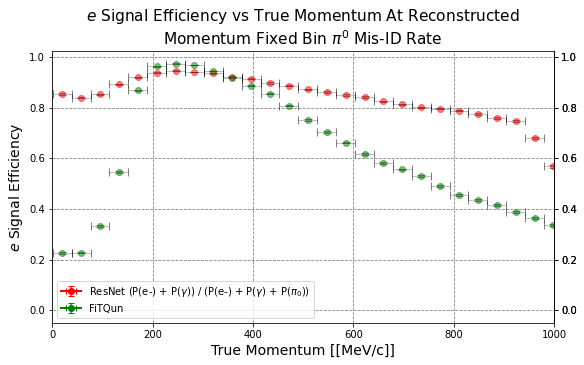

In [46]:
fig, axes = plt.subplots(1,1,figsize=(9,5), facecolor='w')


plot_true_momentum_binned_performance(scores_list       = [scores_list[0]], 
                                 labels_list            = [labels_list[0]],
                                 reconstructed_momentum = filtered_pion_fq_mom,
                                 fpr_fixed_point        = 0.05, 
                                 momentum_features      = filtered_test_true_mom,
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 30,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 marker                 = 'o',
                                 xrange                 = [0, 1000],
                                 #yrange                 = yrange,
                                 ax                     = axes,
                                 desired_labels         = ['$e$',"$\pi^0$"],
                                 show_x_err             = True
                               )

plot_single_var_pion_binned_performance(scores               = scores_list[1],
                                      labels                 = labels_list[1],  
                                      fixed_binning_features = filtered_pion_fq_mom,
                                      fixed_bin_label        = 'Reconstructed Momentum',
                                      plot_binning_features  = filtered_test_true_mom,
                                      plot_bin_label         = 'True Momentum',
                                      p0                     = p0, 
                                      p1                     = p1, 
                                      pi0mass                = filtered_pion_fq_masses,
                                      fpr_fixed_point        = 0.05, 
                                      index_dict             = label_dict, 
                                      fixed_bin_size         = 50, 
                                      plot_bins              = 30, 
                                      xrange                 = [0, 1000],
                                      marker                 = 'o',
                                      color                  = 'g',
                                      title_note             = '',
                                      metric                 = 'efficiency',
                                      #yrange                  = [0.85, 1.01]
                                      ax                     = axes,
                                      names                  = names
                                      )


custom_lines = [Line2D([0], [0], marker='o', linewidth=2, color='r', label='Scatter',
                          markerfacecolor='r'),
                Line2D([0], [0], marker='o', linewidth=2, color='g', label='Scatter',
                          markerfacecolor='g'),
                ]

barline = LineCollection(np.empty((2,2,2)))
err_lines = [ErrorbarContainer((line, [line], [barline]), has_xerr=True, has_yerr=True) for line in custom_lines]
labels = ['ResNet (P(e-) + P($\gamma$)) / (P(e-) + P($\gamma$) + P($\pi_0$))'.format(0.005*100),
          'FiTQun']

leg = axes.legend(handles=err_lines, labels=labels, handlelength=2.0)

Empty bin
Empty bin


"\nhandles, labels = axes.get_legend_handles_labels()\nprint(handles)\n\ncustom_lines = [Line2D([0], [0], marker='o', linewidth=2, color='r', label='Scatter',\n                          markerfacecolor='r'),\n                Line2D([0], [0], marker='o', linewidth=2, color='g', label='Scatter',\n                          markerfacecolor='g'),\n                ]\n\nbarline = LineCollection(np.empty((2,2,2)))\nerr_lines = [ErrorbarContainer((line, [line], [barline]), has_xerr=True, has_yerr=True) for line in custom_lines]\nlabels = ['ResNet (P(e-) + P($\\gamma$)) / (P(e-) + P($\\gamma$) + P($\\pi_0$))'.format(0.005*100),\n          'FiTQun']\n\nleg = axes.legend(handles=err_lines, labels=labels, handlelength=2.0)\n\n\n#handles, labels = axes.get_legend_handles_labels()\nhandles, labels = axes.get_legend_handles_labels()\nprint(handles)\n\nprint(leg.get_texts()[0])\n"

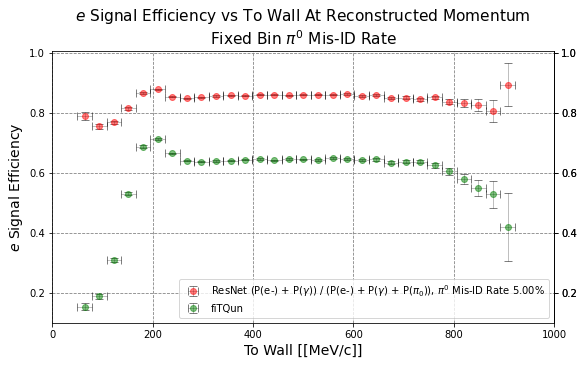

In [47]:
fig, axes = plt.subplots(1,1,figsize=(9,5), facecolor='w')


plot_to_wall_binned_performance(scores_list            = [scores_list[0]], 
                                 labels_list            = [labels_list[0]],
                                 reconstructed_momentum = filtered_pion_fq_mom,
                                 fpr_fixed_point        = 0.05, 
                                 to_wall_features       = filtered_test_to_wall,
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 30,
                                 title_note             = '',
                                 colors                 = colors,
                                 names                  = ['ResNet (P(e-) + P($\gamma$)) / (P(e-) + P($\gamma$) + P($\pi_0$))'.format(0.005*100)],
                                 marker                 = 'o',
                                 xrange                 = [0, 1000],
                                 #yrange                 = yrange,
                                 ax                     = axes,
                                 desired_labels         = ['$e$',"$\pi^0$"],
                                 show_x_err             = True
                               )


plot_single_var_pion_binned_performance(scores               = scores_list[1],
                                      labels                 = labels_list[1],  
                                      fixed_binning_features = filtered_pion_fq_mom,
                                      fixed_bin_label        = 'Reconstructed Momentum',
                                      plot_binning_features  = filtered_test_to_wall,
                                      plot_bin_label         = 'To Wall',
                                      p0                     = p0, 
                                      p1                     = p1, 
                                      pi0mass                = filtered_pion_fq_masses,
                                      fpr_fixed_point        = 0.05, 
                                      index_dict             = label_dict, 
                                      fixed_bin_size         = 50, 
                                      plot_bins              = 30, 
                                      xrange                 = [0, 1000],
                                      marker                 = 'o',
                                      color                  = 'g',
                                      names                  = ['fiTQun'],
                                      title_note             = '',
                                      metric                 = 'efficiency',
                                      #yrange                  = [0.85, 1.01]
                                      ax                     = axes,
                                      )

'''
handles, labels = axes.get_legend_handles_labels()
print(handles)

custom_lines = [Line2D([0], [0], marker='o', linewidth=2, color='r', label='Scatter',
                          markerfacecolor='r'),
                Line2D([0], [0], marker='o', linewidth=2, color='g', label='Scatter',
                          markerfacecolor='g'),
                ]

barline = LineCollection(np.empty((2,2,2)))
err_lines = [ErrorbarContainer((line, [line], [barline]), has_xerr=True, has_yerr=True) for line in custom_lines]
labels = ['ResNet (P(e-) + P($\gamma$)) / (P(e-) + P($\gamma$) + P($\pi_0$))'.format(0.005*100),
          'FiTQun']

leg = axes.legend(handles=err_lines, labels=labels, handlelength=2.0)


#handles, labels = axes.get_legend_handles_labels()
handles, labels = axes.get_legend_handles_labels()
print(handles)

print(leg.get_texts()[0])
'''

Empty bin
Empty bin


"\nhandles, labels = axes.get_legend_handles_labels()\nprint(handles)\n\ncustom_lines = [Line2D([0], [0], marker='o', linewidth=2, color='r', label='Scatter',\n                          markerfacecolor='r'),\n                Line2D([0], [0], marker='o', linewidth=2, color='g', label='Scatter',\n                          markerfacecolor='g'),\n                ]\n\nbarline = LineCollection(np.empty((2,2,2)))\nerr_lines = [ErrorbarContainer((line, [line], [barline]), has_xerr=True, has_yerr=True) for line in custom_lines]\nlabels = ['ResNet (P(e-) + P($\\gamma$)) / (P(e-) + P($\\gamma$) + P($\\pi_0$))'.format(0.005*100),\n          'FiTQun']\n\nleg = axes.legend(handles=err_lines, labels=labels, handlelength=2.0)\n\n\n#handles, labels = axes.get_legend_handles_labels()\nhandles, labels = axes.get_legend_handles_labels()\nprint(handles)\n\nprint(leg.get_texts()[0])\n"

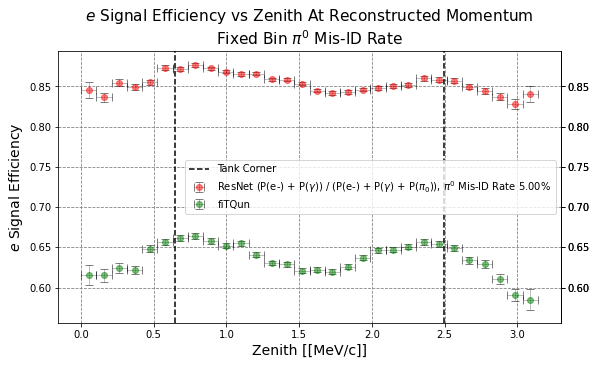

In [57]:
fig, axes = plt.subplots(1,1,figsize=(9,5), facecolor='w')


plot_zenith_binned_performance(scores_list             = [scores_list[0]], 
                                 labels_list            = [labels_list[0]],
                                 reconstructed_momentum = filtered_pion_fq_mom,
                                 fpr_fixed_point        = 0.05, 
                                 zenith_features       = filtered_test_zenith,
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 30,
                                 title_note             = '',
                                 colors                 = colors,
                                 names                  = ['ResNet (P(e-) + P($\gamma$)) / (P(e-) + P($\gamma$) + P($\pi_0$))'.format(0.005*100)],
                                 marker                 = 'o',
                                 #xrange                 = [0, 1000],
                                 #yrange                 = yrange,
                                 ax                     = axes,
                                 desired_labels         = ['$e$',"$\pi^0$"],
                                 show_x_err             = True
                               )


plot_single_var_pion_binned_performance(scores               = scores_list[1],
                                      labels                 = labels_list[1],  
                                      fixed_binning_features = filtered_pion_fq_mom,
                                      fixed_bin_label        = 'Reconstructed Momentum',
                                      plot_binning_features  = filtered_test_zenith,
                                      plot_bin_label         = 'Zenith',
                                      p0                     = p0, 
                                      p1                     = p1, 
                                      pi0mass                = filtered_pion_fq_masses,
                                      fpr_fixed_point        = 0.05, 
                                      index_dict             = label_dict, 
                                      fixed_bin_size         = 50, 
                                      plot_bins              = 30, 
                                      #xrange                 = [0, 1000],
                                      marker                 = 'o',
                                      color                  = 'g',
                                      names                  = ['fiTQun'],
                                      title_note             = '',
                                      metric                 = 'efficiency',
                                      #yrange                  = [0.85, 1.01]
                                      ax                     = axes,
                                      )

'''
handles, labels = axes.get_legend_handles_labels()
print(handles)

custom_lines = [Line2D([0], [0], marker='o', linewidth=2, color='r', label='Scatter',
                          markerfacecolor='r'),
                Line2D([0], [0], marker='o', linewidth=2, color='g', label='Scatter',
                          markerfacecolor='g'),
                ]

barline = LineCollection(np.empty((2,2,2)))
err_lines = [ErrorbarContainer((line, [line], [barline]), has_xerr=True, has_yerr=True) for line in custom_lines]
labels = ['ResNet (P(e-) + P($\gamma$)) / (P(e-) + P($\gamma$) + P($\pi_0$))'.format(0.005*100),
          'FiTQun']

leg = axes.legend(handles=err_lines, labels=labels, handlelength=2.0)


#handles, labels = axes.get_legend_handles_labels()
handles, labels = axes.get_legend_handles_labels()
print(handles)

print(leg.get_texts()[0])
'''

Empty bin
Empty bin


"\nhandles, labels = axes.get_legend_handles_labels()\nprint(handles)\n\ncustom_lines = [Line2D([0], [0], marker='o', linewidth=2, color='r', label='Scatter',\n                          markerfacecolor='r'),\n                Line2D([0], [0], marker='o', linewidth=2, color='g', label='Scatter',\n                          markerfacecolor='g'),\n                ]\n\nbarline = LineCollection(np.empty((2,2,2)))\nerr_lines = [ErrorbarContainer((line, [line], [barline]), has_xerr=True, has_yerr=True) for line in custom_lines]\nlabels = ['ResNet (P(e-) + P($\\gamma$)) / (P(e-) + P($\\gamma$) + P($\\pi_0$))'.format(0.005*100),\n          'FiTQun']\n\nleg = axes.legend(handles=err_lines, labels=labels, handlelength=2.0)\n\n\n#handles, labels = axes.get_legend_handles_labels()\nhandles, labels = axes.get_legend_handles_labels()\nprint(handles)\n\nprint(leg.get_texts()[0])\n"

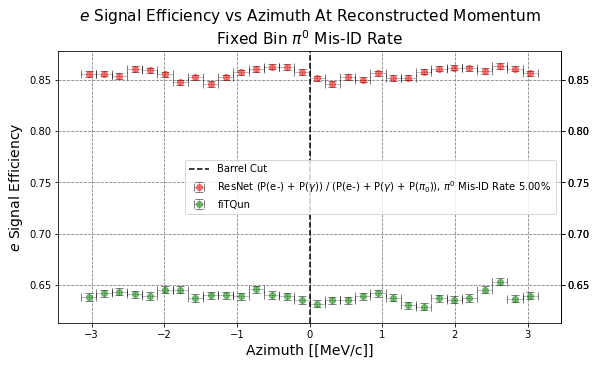

In [59]:
fig, axes = plt.subplots(1,1,figsize=(9,5), facecolor='w')


plot_azimuth_binned_performance(scores_list             = [scores_list[0]], 
                                 labels_list            = [labels_list[0]],
                                 reconstructed_momentum = filtered_pion_fq_mom,
                                 fpr_fixed_point        = 0.05, 
                                 azimuth_features       = filtered_test_azimuth,
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 30,
                                 title_note             = '',
                                 colors                 = colors,
                                 names                  = ['ResNet (P(e-) + P($\gamma$)) / (P(e-) + P($\gamma$) + P($\pi_0$))'.format(0.005*100)],
                                 marker                 = 'o',
                                 #xrange                 = [0, 1000],
                                 #yrange                 = yrange,
                                 ax                     = axes,
                                 desired_labels         = ['$e$',"$\pi^0$"],
                                 show_x_err             = True
                               )


plot_single_var_pion_binned_performance(scores               = scores_list[1],
                                      labels                 = labels_list[1],  
                                      fixed_binning_features = filtered_pion_fq_mom,
                                      fixed_bin_label        = 'Reconstructed Momentum',
                                      plot_binning_features  = filtered_test_azimuth,
                                      plot_bin_label         = 'Azimuth',
                                      p0                     = p0, 
                                      p1                     = p1, 
                                      pi0mass                = filtered_pion_fq_masses,
                                      fpr_fixed_point        = 0.05, 
                                      index_dict             = label_dict, 
                                      fixed_bin_size         = 50, 
                                      plot_bins              = 30, 
                                      #xrange                 = [0, 1000],
                                      marker                 = 'o',
                                      color                  = 'g',
                                      names                  = ['fiTQun'],
                                      title_note             = '',
                                      metric                 = 'efficiency',
                                      #yrange                  = [0.85, 1.01]
                                      ax                     = axes,
                                      )

'''
handles, labels = axes.get_legend_handles_labels()
print(handles)

custom_lines = [Line2D([0], [0], marker='o', linewidth=2, color='r', label='Scatter',
                          markerfacecolor='r'),
                Line2D([0], [0], marker='o', linewidth=2, color='g', label='Scatter',
                          markerfacecolor='g'),
                ]

barline = LineCollection(np.empty((2,2,2)))
err_lines = [ErrorbarContainer((line, [line], [barline]), has_xerr=True, has_yerr=True) for line in custom_lines]
labels = ['ResNet (P(e-) + P($\gamma$)) / (P(e-) + P($\gamma$) + P($\pi_0$))'.format(0.005*100),
          'FiTQun']

leg = axes.legend(handles=err_lines, labels=labels, handlelength=2.0)


#handles, labels = axes.get_legend_handles_labels()
handles, labels = axes.get_legend_handles_labels()
print(handles)

print(leg.get_texts()[0])
'''

## Multiple Variable Plotting

<class 'float'>
{'Energy Range $400.0-600.0$ $MeV$', 'Energy Range $600.0-800.0$ $MeV$', 'Energy Range $0.0-200.0$ $MeV$', 'Energy Range $200.0-400.0$ $MeV$', 'Energy Range $800.0-1000.0$ $MeV$'}
<class 'NoneType'>
{'Energy Range $400.0-600.0$ $MeV$', 'Energy Range $600.0-800.0$ $MeV$', 'Energy Range $0.0-200.0$ $MeV$', 'Energy Range $200.0-400.0$ $MeV$', 'Energy Range $800.0-1000.0$ $MeV$'}


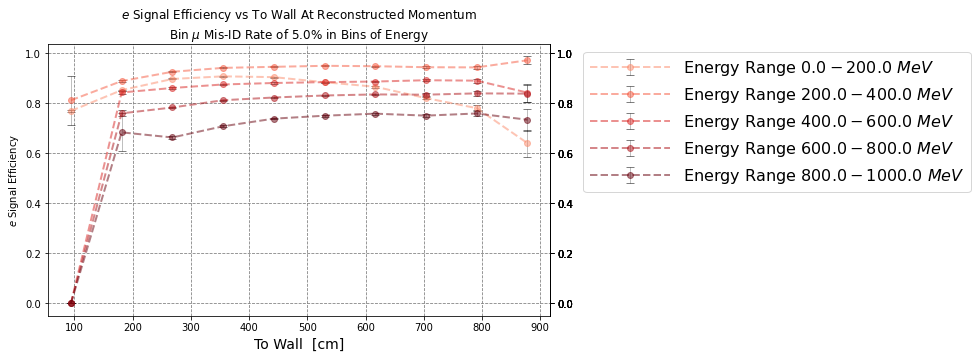

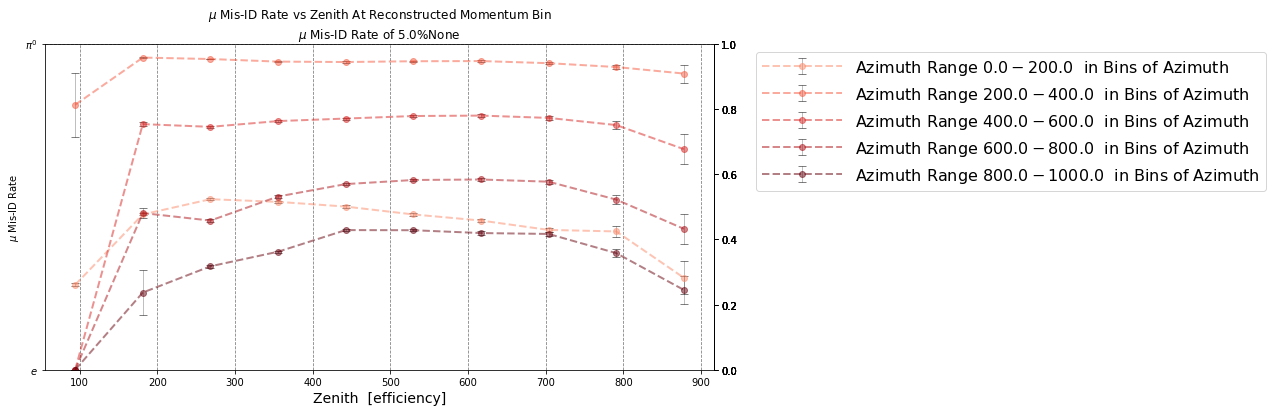

In [67]:
fig, axes = plt.subplots(1,1,figsize=(9,5), facecolor='w')

plot_to_wall_binned_in_energy(scores_list            = [scores_list[0]], 
                              labels_list            = [labels_list[0]],
                              reconstructed_momentum = filtered_fq_mom,
                              binning_features       = filtered_test_energies,
                              binning_bin_size       = 200,
                              to_wall_features       = filtered_test_to_wall,
                              fpr_fixed_point        = 0.05, 
                              index_dict             = label_dict, 
                              recons_mom_bin_size    = 50, 
                              plot_bins              = 10,
                              names                  = names,
                              desired_labels         = ['$e$',"$\pi^0$"],
                              axes                   = axes,
                                 colors                 = colors
                              )


plot_pion_multi_var_binned_performance(scores_list   = [scores_list[1]], 
                              labels_list            = [labels_list[1]],
                              reconstructed_momentum = filtered_fq_mom,
                              binning_features       = filtered_test_energies,
                              binning_bin_size       = 200,
                              plot_binning_features   = filtered_test_to_wall,
                              p0                     = p0, 
                              p1                     = p1, 
                              pi0mass                = filtered_pion_fq_masses,
                              fpr_fixed_point        = 0.05, 
                              index_dict             = label_dict, 
                              recons_mom_bin_size    = 50, 
                              plot_bins              = 10,
                              names                  = names,
                              desired_labels         = ['$e$',"$\pi^0$"],
                              axes                   = axes,
                                 colors                 = colors
                              )

<class 'float'>
{'Zenith Range $2.0-2.5$ Radians', 'Zenith Range $1.5-2.0$ Radians', 'Zenith Range $0.5-1.0$ Radians', 'Zenith Range $2.5-3.0$ Radians', 'Zenith Range $1.0-1.5$ Radians', 'Zenith Range $0.0-0.5$ Radians'}
{'Zenith Range $2.0-2.5$ Radians', 'Zenith Range $1.5-2.0$ Radians', 'Zenith Range $0.5-1.0$ Radians', 'Barrel Cut', 'Zenith Range $2.5-3.0$ Radians', 'Zenith Range $1.0-1.5$ Radians', 'Zenith Range $0.0-0.5$ Radians'}
<class 'NoneType'>
set()


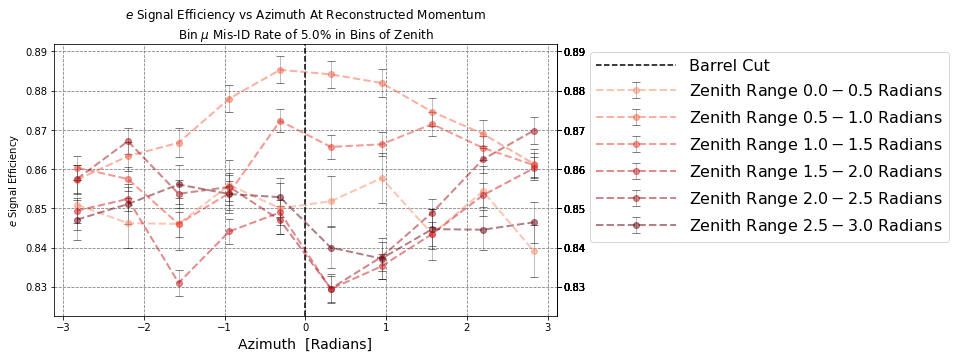

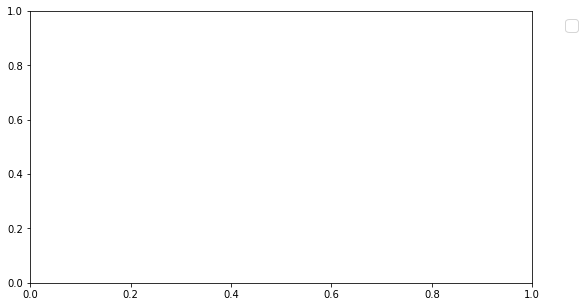

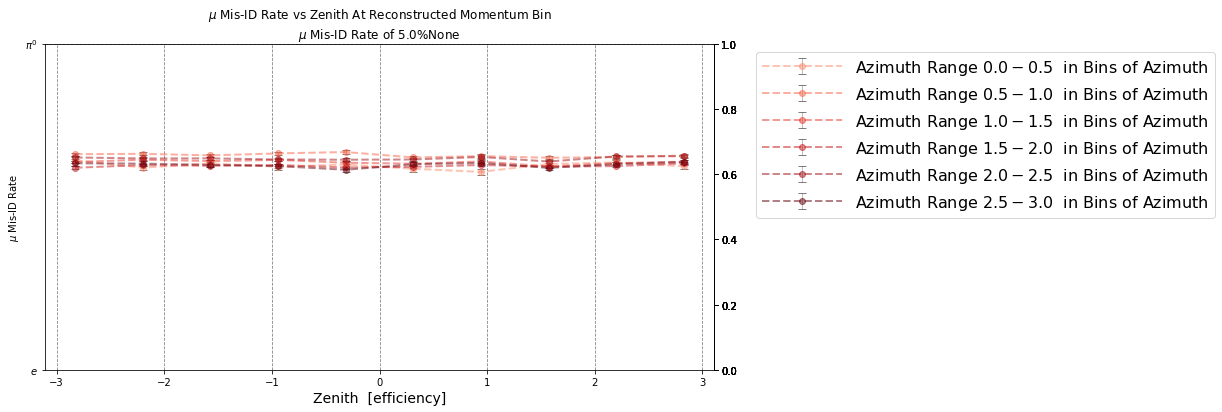

In [68]:
plot_azimuth_binned_in_zenith(scores_list            = [scores_list[0]], 
                              labels_list            = [labels_list[0]],
                              reconstructed_momentum = filtered_fq_mom,
                              binning_features       = filtered_test_zenith,
                              binning_bin_size       = 0.5,
                              azimuth_features       = filtered_test_azimuth,
                              fpr_fixed_point        = 0.05, 
                              index_dict             = label_dict, 
                              recons_mom_bin_size    = 50, 
                              plot_bins              = 10,
                              names                  = names,
                              desired_labels         = ['$e$', "$\pi^0$"],
                                 colors                 = colors
                              )


plot_pion_multi_var_binned_performance(scores_list   = [scores_list[1]], 
                              labels_list            = [labels_list[1]],
                              reconstructed_momentum = filtered_fq_mom,
                              binning_features       = filtered_test_zenith,
                              binning_bin_size       = 0.5,
                              plot_binning_features  = filtered_test_azimuth,
                              p0                     = p0, 
                              p1                     = p1, 
                              pi0mass                = filtered_pion_fq_masses,
                              fpr_fixed_point        = 0.05, 
                              index_dict             = label_dict, 
                              recons_mom_bin_size    = 50, 
                              plot_bins              = 10,
                              names                  = names,
                              desired_labels         = ['$e$',"$\pi^0$"],
                                 colors                 = colors
                              )

<class 'float'>
{'Azimuth Range $2.0-2.5$ Radians', 'Azimuth Range $1.5-2.0$ Radians', 'Azimuth Range $0.5-1.0$ Radians', 'Azimuth Range $2.5-3.0$ Radians', 'Azimuth Range $1.0-1.5$ Radians', 'Azimuth Range $0.0-0.5$ Radians'}
{'Tank Corner', 'Azimuth Range $2.0-2.5$ Radians', 'Azimuth Range $1.5-2.0$ Radians', 'Azimuth Range $0.5-1.0$ Radians', 'Azimuth Range $2.5-3.0$ Radians', 'Azimuth Range $1.0-1.5$ Radians', 'Azimuth Range $0.0-0.5$ Radians'}


TypeError: 'NoneType' object is not subscriptable

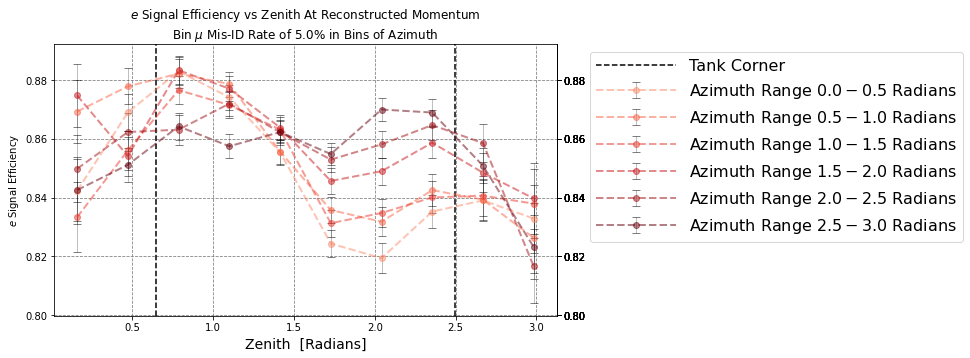

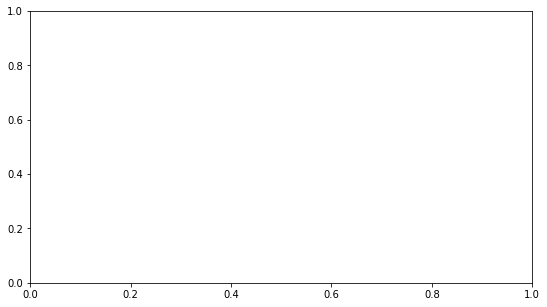

In [69]:
plot_zenith_binned_in_azimuth(scores_list            = [scores_list[0]], 
                              labels_list            = [labels_list[0]],
                              reconstructed_momentum = filtered_fq_mom,
                              binning_features       = filtered_test_azimuth,
                              binning_bin_size       = 0.5,
                              zenith_features        = filtered_test_zenith,
                              fpr_fixed_point        = 0.05, 
                              index_dict             = label_dict, 
                              recons_mom_bin_size    = 50, 
                              plot_bins              = 10,
                              names                  = names,
                              desired_labels         = ['$e$',"$\pi^0$"] ,
                                 colors                 = colors
                              )

plot_pion_multi_var_binned_performance(scores_list   = [scores_list[1]], 
                              labels_list            = [labels_list[1]],
                              reconstructed_momentum = filtered_fq_mom,
                              binning_features       = filtered_test_azimuth,
                              binning_bin_size       = 0.5,
                              plot_binning_features  = filtered_test_zenith,
                              p0                     = p0, 
                              p1                     = p1, 
                              pi0mass                = filtered_pion_fq_masses,
                              fpr_fixed_point        = 0.05, 
                              index_dict             = label_dict, 
                              recons_mom_bin_size    = 50, 
                              plot_bins              = 10,
                              names                  = names,
                              desired_labels         = ['$e$',"$\pi^0$"]
                              )

In [70]:
from WatChMaL.analysis.performance_analysis_plot_utils import  plot_2D_hist

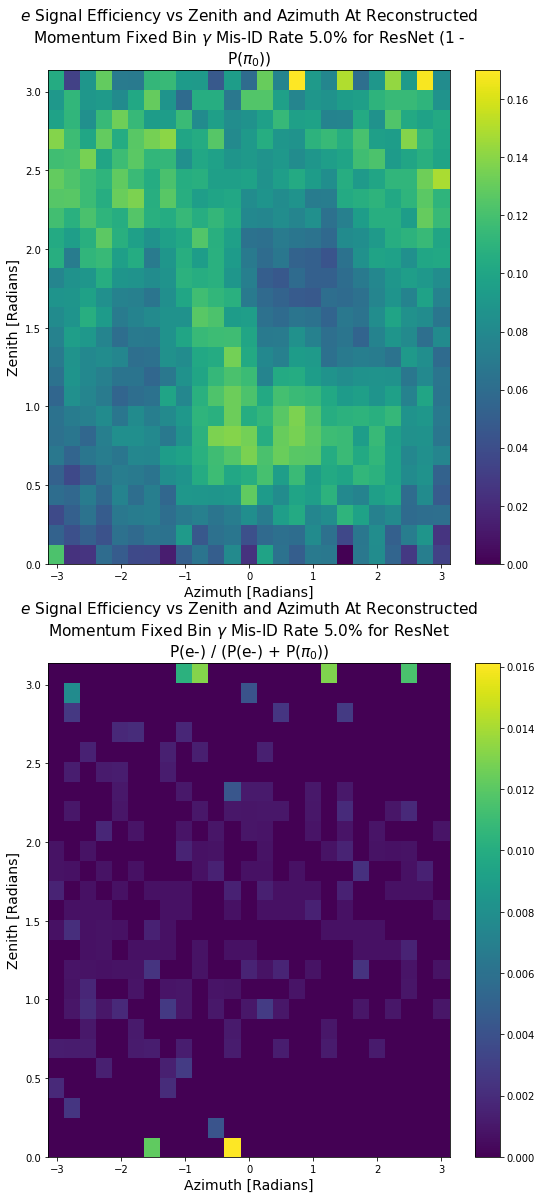

In [73]:
plot_2D_hist(scores_list            = scores_list, 
             labels_list            = labels_list,
             reconstructed_momentum = filtered_fq_mom,
             binning_features       = filtered_test_zenith,
             binning_bins           = 25,
             plot_binning_features  = filtered_test_azimuth,
             fpr_fixed_point        = 0.05, 
             index_dict             = label_dict, 
             recons_mom_bin_size    = 50, 
             plot_bins              = 25,
             names                  = names,
             colors                 = colors,
             desired_labels         = ['$e$','$\gamma$']
             )